<a href="https://colab.research.google.com/github/shibasis0801/MachineLearningPractice/blob/master/books/DeepLearningWithKeras/CNN/CatsVsDogs_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-08-15 06:48:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  89.1MB/s    in 0.7s    

2020-08-15 06:48:30 (89.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
import os
from os.path import join as pjoin
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
base_dir = "/tmp/cats_and_dogs_filtered"

dir_train = pjoin(base_dir, "train")
dir_validation = pjoin(base_dir, "validation")

dir_train_cats = pjoin(dir_train, "cats")
dir_validation_cats = pjoin(dir_validation, "cats")

dir_train_dogs = pjoin(dir_train, "dogs")
dir_validation_dogs = pjoin(dir_validation, "dogs")

In [7]:
from tensorflow.keras.applications import VGG16
vgg16 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=(150, 150, 3)
)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory, 
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, label_batch in generator:
    features_batch = vgg16.predict(input_batch)
    start = i * batch_size
    end = (i + 1) * batch_size
    features[ start : end ] = features_batch
    labels[ start : end ] = label_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

  

In [10]:
train_features, train_labels = extract_features(dir_train, 2000)
val_features, val_labels = extract_features(dir_validation, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))

In [34]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [35]:
history = model.fit(
    train_features, train_labels,
    batch_size=batch_size,
    epochs=30,
    validation_data=(val_features, val_labels)
)

Epoch 1/30
100/100 [==============================] - 0s 5ms/step - loss: 0.5829 - acc: 0.6865 - val_loss: 0.4256 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4191 - acc: 0.8150 - val_loss: 0.3573 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3450 - acc: 0.8580 - val_loss: 0.3253 - val_acc: 0.8650
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3103 - acc: 0.8730 - val_loss: 0.3103 - val_acc: 0.8610
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2819 - acc: 0.8845 - val_loss: 0.2939 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2685 - acc: 0.8970 - val_loss: 0.2870 - val_acc: 0.8730
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2497 - acc: 0.9025 - val_loss: 0.2814 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

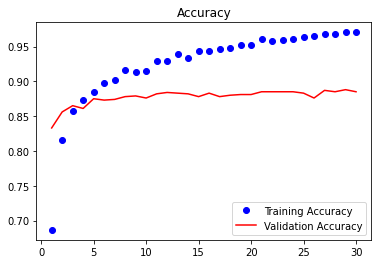

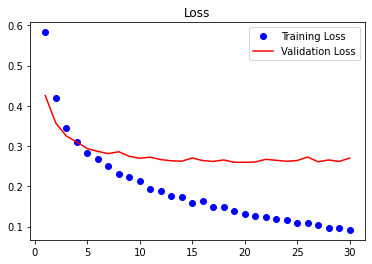

In [36]:
import matplotlib.pyplot as plt

def plot(history):
  acc = history.history['acc']
  loss = history.history['loss']
  val_acc = history.history['val_acc']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
  plt.title("Accuracy")
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title("Loss")
  plt.legend()

  plt.show()

plot(history)

In [37]:
vggmodel = models.Sequential()

vggmodel.add(vgg16)
vggmodel.add(layers.Flatten())
vggmodel.add(layers.Dense(256, activation='relu'))
vggmodel.add(layers.Dense(1, activation='sigmoid'))

vggmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
print("Original trainable weights", len(vggmodel.trainable_weights))

Original trainable weights 4


In [39]:
vgg16.trainable = False
print("New trainable weights", len(vggmodel.trainable_weights))

New trainable weights 4


In [40]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0/255)


In [44]:
train_generator = train_datagen.flow_from_directory(
    dir_train, 
    target_size=(150, 150), 
    class_mode='binary', 
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_directory(
    dir_validation, 
    target_size=(150, 150), 
    class_mode='binary', 
    batch_size=batch_size
)

vggmodel.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [45]:
vgghistory = vggmodel.fit_generator(
    train_generator,
    epochs=30,
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 19s 186ms/step - loss: 0.2800 - acc: 0.8855 - val_loss: 0.2426 - val_acc: 0.8990
Epoch 2/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2740 - acc: 0.8885 - val_loss: 0.2432 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2775 - acc: 0.8740 - val_loss: 0.2528 - val_acc: 0.8970
Epoch 4/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2686 - acc: 0.8825 - val_loss: 0.2555 - val_acc: 0.8960
Epoch 5/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2789 - acc: 0.8735 - val_loss: 0.2472 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2732 - acc: 0.8870 - val_loss: 0.2404 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2767 - acc: 0.8770 - val_loss: 0.2390 - val_acc: 0.8990
Epoch 8/30
100/100 [==============================] - 1

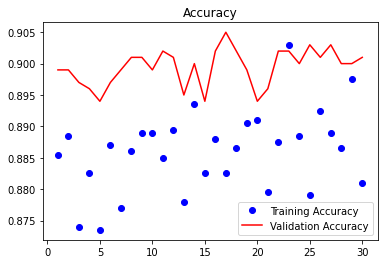

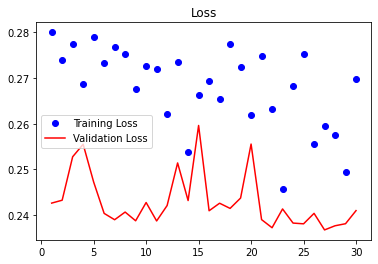

In [46]:
plot(vgghistory)

GETTING MUCH WORSE RESULTS

In [50]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [49]:
[layer.name for layer in vgg16.layers]

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [52]:
for layer in vgg16.layers:
  if 'block5' in layer.name:
    layer.trainable = False

In [53]:
vggmodel.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

In [54]:
vgghistory2 = vggmodel.fit_generator(
    train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2711 - acc: 0.8830 - val_loss: 0.2377 - val_acc: 0.9020
Epoch 2/30
100/100 [==============================] - 19s 185ms/step - loss: 0.2552 - acc: 0.8945 - val_loss: 0.2394 - val_acc: 0.9040
Epoch 3/30
100/100 [==============================] - 19s 185ms/step - loss: 0.2488 - acc: 0.9045 - val_loss: 0.2431 - val_acc: 0.9000
Epoch 4/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2607 - acc: 0.8845 - val_loss: 0.2392 - val_acc: 0.9000
Epoch 5/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2545 - acc: 0.8900 - val_loss: 0.2450 - val_acc: 0.8960
Epoch 6/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2487 - acc: 0.9010 - val_loss: 0.2536 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2554 - acc: 0.8905 - val_loss: 0.2432 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 1

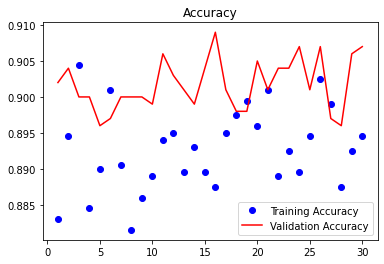

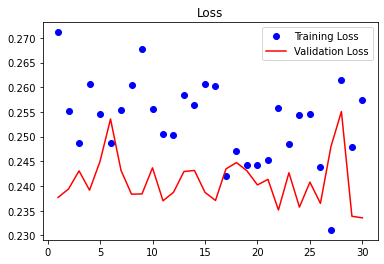

In [55]:
plot(vgghistory2)

# Extremely bad results. Why?